# Forecasting multiple independent time series

[Forecasting for machine learning](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook we will show how to forecast multiple **independent** time series using a **local** and **global** forecasting approach with **traditional machine learning models**. We will use the `skforecast` package to help us do this.

This notebook is adapted from the [skforecast example notebook](https://cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html).

Note: Since recording the videos, skforecast have made breaking changes to their API in newer versions (>= 0.14). This notebook has been updated for use with skforecast version 0.14 and above, which are the versions with a new API. If you are using older versions of skforecast (<0.14) see the migration guide here: https://skforecast.org/0.14.0/user_guides/migration-guide.html

## Data set synopsis

Data has been obtained from [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data), specifically `train.csv`. This dataset contains 913,000 sales transactions from 2013–01–01 to 2017–12–31 for 50 products (SKU) in 10 stores. The goal is to predict the next 7 days sales for 50 different items in one store using the available 5 years history.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data

In [2]:
from skforecast.datasets import fetch_dataset

# Load the data
data = fetch_dataset(name="store_sales", raw=True)
data.head()

store_sales
-----------
This dataset contains 913,000 sales transactions from 2013-01-01 to 2017-12-31
for 50 products (SKU) in 10 stores.
The original data was obtained from: inversion. (2018). Store Item Demand
Forecasting Challenge. Kaggle. https://kaggle.com/competitions/demand-
forecasting-kernels-only
Shape of the dataset: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


`ForecasterRecursiveMultiSeries` requires that each time series is a column in the dataframe and that the index is time-like (datetime or timestamp). 

So now we process the data to get dataframes in the required format.

In [3]:
# Data preprocessing

selected_store = 2
selected_items = data["item"].unique()  # All items
# selected_items = [1, 2, 3, 4, 5] # Selection of items to reduce computation time

# Filter data to specific stores and products
mask = (data["store"] == selected_store) & (data["item"].isin(selected_items))
data = data[mask].copy()

# Convert `date` column to datetime
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

data.head()

,date,store,item,sales
1826,2013-01-01,2,1,12
1827,2013-01-02,2,1,16
1828,2013-01-03,2,1,16
1829,2013-01-04,2,1,20
1830,2013-01-05,2,1,16


In [4]:
# Convert to one column per time series
data = pd.pivot_table(data=data, values="sales", index="date", columns="item")

data.head()

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0,41.0,19.0,21.0,4.0,34.0,39.0,49.0,28.0,51.0,...,11.0,25.0,36.0,12.0,45.0,43.0,12.0,45.0,29.0,43.0
2013-01-02,16.0,33.0,32.0,14.0,6.0,40.0,47.0,42.0,21.0,56.0,...,19.0,21.0,35.0,25.0,50.0,52.0,13.0,37.0,25.0,57.0
2013-01-03,16.0,46.0,26.0,12.0,12.0,41.0,43.0,46.0,29.0,46.0,...,23.0,20.0,52.0,18.0,56.0,30.0,5.0,45.0,30.0,45.0
2013-01-04,20.0,50.0,34.0,17.0,16.0,41.0,44.0,55.0,32.0,56.0,...,15.0,28.0,50.0,24.0,57.0,46.0,19.0,32.0,20.0,45.0
2013-01-05,16.0,44.0,25.0,14.0,9.0,47.0,55.0,64.0,45.0,53.0,...,19.0,39.0,41.0,19.0,78.0,41.0,18.0,53.0,20.0,55.0


In [5]:
# Reset column names
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]

# Explicitly set the frequency of the data to daily.
# This would introduce missing values for missing days.
data = data.asfreq("1D")

# Sort by time
data = data.sort_index()

data.head()

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0,41.0,19.0,21.0,4.0,34.0,39.0,49.0,28.0,51.0,...,11.0,25.0,36.0,12.0,45.0,43.0,12.0,45.0,29.0,43.0
2013-01-02,16.0,33.0,32.0,14.0,6.0,40.0,47.0,42.0,21.0,56.0,...,19.0,21.0,35.0,25.0,50.0,52.0,13.0,37.0,25.0,57.0
2013-01-03,16.0,46.0,26.0,12.0,12.0,41.0,43.0,46.0,29.0,46.0,...,23.0,20.0,52.0,18.0,56.0,30.0,5.0,45.0,30.0,45.0
2013-01-04,20.0,50.0,34.0,17.0,16.0,41.0,44.0,55.0,32.0,56.0,...,15.0,28.0,50.0,24.0,57.0,46.0,19.0,32.0,20.0,45.0
2013-01-05,16.0,44.0,25.0,14.0,9.0,47.0,55.0,64.0,45.0,53.0,...,19.0,39.0,41.0,19.0,78.0,41.0,18.0,53.0,20.0,55.0


In [6]:
# Check if any missing values introduced
data.isnull().sum().any()

False

Four of the series are plotted to understand their trends and patterns. The reader is strongly encouraged to plot several more to gain an in-depth understanding of the series.



/var/folders/xw/0ks6s8x53lvf4p3xdqzfh9300000gn/T/ipykernel_10400/1227022470.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


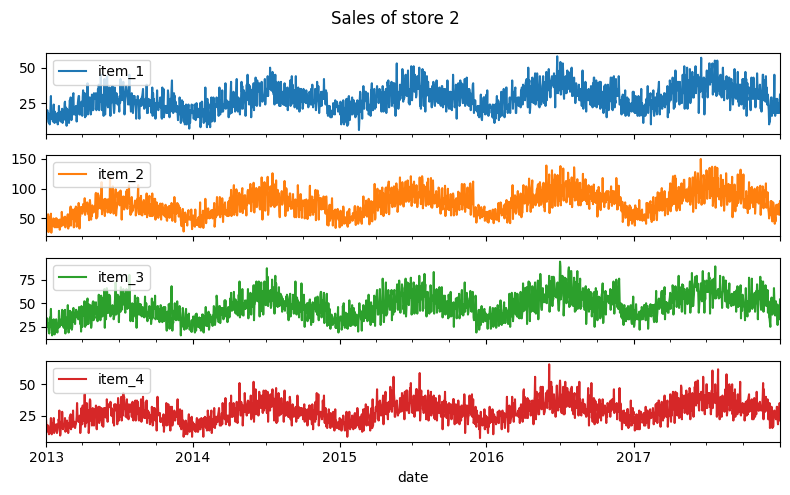

In [7]:
# Plot a subset of the time series
fig, ax = plt.subplots(figsize=(8, 5))
data.iloc[:, :4].plot(
    legend=True,
    subplots=True,
    sharex=True,
    title="Sales of store 2",
    ax=ax,
)
fig.tight_layout()

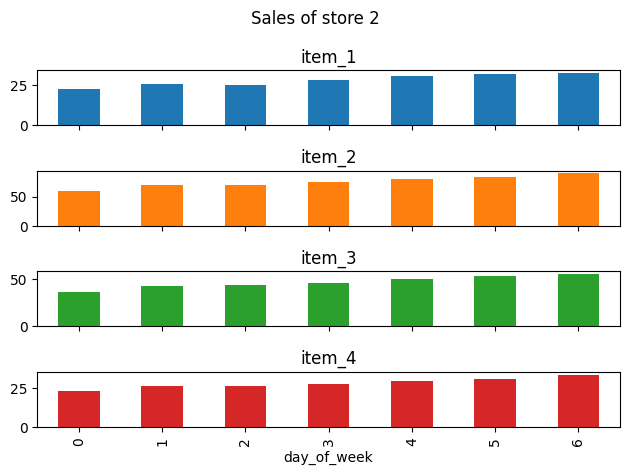

In [8]:
# Quick and dirty plot to check for weekly seasonality
(
    data.assign(day_of_week=lambda x: data.index.weekday).groupby("day_of_week").mean()
).iloc[:, :4].plot(
    legend=False,
    subplots=True,
    sharex=True,
    title="Sales of store 2",
    kind="bar",
)
plt.tight_layout()

Let's add the day of the week to use as an exogenous feature.

In [9]:
data["day_of_week"] = data.index.weekday

# Linear models would better capture seasonality using fourier or cyclical features.
# Read more about them here:
# https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.fourier.FourierFeatures.html
# https://feature-engine.trainindata.com/en/latest/user_guide/creation/CyclicalFeatures.html#cyclical-features

In [10]:
data

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0,41.0,19.0,21.0,4.0,34.0,39.0,49.0,28.0,51.0,...,25.0,36.0,12.0,45.0,43.0,12.0,45.0,29.0,43.0,1
2013-01-02,16.0,33.0,32.0,14.0,6.0,40.0,47.0,42.0,21.0,56.0,...,21.0,35.0,25.0,50.0,52.0,13.0,37.0,25.0,57.0,2
2013-01-03,16.0,46.0,26.0,12.0,12.0,41.0,43.0,46.0,29.0,46.0,...,20.0,52.0,18.0,56.0,30.0,5.0,45.0,30.0,45.0,3
2013-01-04,20.0,50.0,34.0,17.0,16.0,41.0,44.0,55.0,32.0,56.0,...,28.0,50.0,24.0,57.0,46.0,19.0,32.0,20.0,45.0,4
2013-01-05,16.0,44.0,25.0,14.0,9.0,47.0,55.0,64.0,45.0,53.0,...,39.0,41.0,19.0,78.0,41.0,18.0,53.0,20.0,55.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.0,74.0,36.0,26.0,20.0,56.0,65.0,79.0,51.0,63.0,...,33.0,45.0,31.0,99.0,59.0,22.0,48.0,30.0,79.0,2
2017-12-28,21.0,69.0,40.0,23.0,18.0,63.0,73.0,91.0,60.0,78.0,...,46.0,64.0,31.0,99.0,64.0,24.0,37.0,31.0,68.0,3
2017-12-29,18.0,56.0,33.0,21.0,25.0,72.0,69.0,99.0,48.0,76.0,...,56.0,59.0,37.0,91.0,78.0,33.0,56.0,33.0,67.0,4


# Local forecasting approach: Training one model per time series

A different model is trained for each item of the store.

In [11]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Forecasters from skforecast
from skforecast.recursive import ForecasterRecursive 
from skforecast.preprocessing import RollingFeatures

In [12]:
# Define a RollingFeatures object to extract window features.
# The RollingFeatures object is used with an skforecast Forecaster object.
# Calculate rolling mean and standard deviation with window 7 and 30.
window_features = RollingFeatures(
    stats = ["mean", "std"], # The statistics to calculate
    window_sizes = [7, 30], # The window sizes to calculate the statistics
)

window_features

RollingFeatures(
    stats           = ['mean', 'std'],
    window_sizes    = [7, 30],
    Max window size = 30,
    min_periods     = [7, 30],
    features_names  = ['roll_mean_7', 'roll_std_30'],
    fillna          = None
)

In [13]:
# Create forecaster
forecaster = ForecasterRecursive(
    regressor=Ridge(alpha=1),
    lags=7,
    window_features=window_features,
    transformer_y=StandardScaler(),
    transformer_exog=StandardScaler(),
)

# REFERENCE: To create forecaster with only lag features and no window features
# forecaster = ForecasterRecursive(
#     regressor=Ridge(alpha=1),
#     lags=7,
#     transformer_y=StandardScaler(),
#     transformer_exog=StandardScaler(),
# )

In [14]:
# Check the feature matrix and target variable
# created by the `forecaster` object.
time_series_1 = data["item_1"]
X_train, y_train = forecaster.create_train_X_y(y=time_series_1)
display(X_train.head(), y_train.head())

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,roll_mean_7,roll_std_30
date,,,,,,,,,
2013-01-31,-2.094062,-1.172258,-1.517935,-1.863611,-1.633160,-1.287484,-1.633160,-1.600239,0.501192
2013-02-01,-1.402709,-2.094062,-1.172258,-1.517935,-1.863611,-1.633160,-1.287484,-1.567317,0.494818
2013-02-02,-1.402709,-1.402709,-2.094062,-1.172258,-1.517935,-1.863611,-1.633160,-1.583778,0.494818
2013-02-03,-0.596131,-1.402709,-1.402709,-2.094062,-1.172258,-1.517935,-1.863611,-1.435631,0.517506
2013-02-04,-1.633160,-0.596131,-1.402709,-1.402709,-2.094062,-1.172258,-1.517935,-1.402709,0.511812


date
2013-01-31   -1.402709
2013-02-01   -1.402709
2013-02-02   -0.596131
2013-02-03   -1.633160
2013-02-04   -1.172258
Freq: D, Name: y, dtype: float64

In [15]:
# Target time series column names
target_cols = data.filter(like="item_").columns

# Exogenous feature column names
exog_cols = ["day_of_week"]

# Forecast horizon: Number of steps to predict
steps = 14

In [16]:
freq = data.index.freq.name
future_start_date = data.index.max() + pd.Timedelta(f"1{freq}")
future_dates = pd.date_range(start=future_start_date, freq=freq, periods=steps)

In [17]:
# Prepare exogenous features for the future
freq = data.index.freq.name
future_start_date = data.index.max() + pd.Timedelta(f"1{freq}")
future_dates = pd.date_range(start=future_start_date, freq=freq, periods=steps)

future_exog = pd.DataFrame(index=future_dates)
future_exog["day_of_week"] = future_exog.index.weekday

In [18]:
# Prepare containers to store predictions
models = {}
predictions = {}

# Train a model and make a forecast for each time series
for item in target_cols:

    # Create forecaster
    forecaster = ForecasterRecursive(
        regressor=Ridge(alpha=1),
        lags=7,
        window_features=window_features,
        transformer_y=StandardScaler(),
        transformer_exog=StandardScaler(),
    )


    # Fit model
    forecaster.fit(y=data[item], exog=data[exog_cols])

    y_pred = forecaster.predict(steps=14, exog=future_exog)

    models[item] = forecaster
    predictions[item] = y_pred

# Results
forecast = pd.DataFrame(predictions)
forecast

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
2018-01-01,18.549904,53.936748,30.407098,20.722580,15.847531,48.603647,52.308288,74.566527,41.172185,59.984216,...,17.355365,34.635380,45.338513,24.249609,75.337111,51.564454,20.572314,40.999026,25.627979,54.061797
2018-01-02,20.316138,59.545877,35.299444,22.124135,16.426975,51.381946,56.615235,84.103657,48.561634,68.537023,...,18.698909,38.182985,49.697001,26.039333,86.186224,57.370818,21.854591,43.944420,29.277943,57.970051
2018-01-03,20.964532,62.867503,35.558011,23.784073,17.769704,54.869677,60.751930,86.163422,50.825809,71.739606,...,20.790382,40.851203,52.119604,27.183104,90.000536,60.767928,22.416526,46.880573,29.407666,64.071610
2018-01-04,22.794369,66.097743,38.129304,25.066995,19.024840,59.581210,64.395621,93.921840,55.249360,77.225287,...,22.381160,44.698916,57.365338,28.980793,93.540548,65.780981,24.157202,50.253366,31.548074,66.784539
2018-01-05,25.072128,68.597503,41.002158,26.408808,20.916326,64.621960,68.577780,100.182221,58.597927,84.101042,...,24.701001,48.465972,60.479425,31.457555,98.913556,71.831652,26.235989,56.988060,33.891638,71.403390
2018-01-06,27.538195,75.411098,45.655771,29.322767,22.200031,68.419489,73.759643,106.810480,63.647315,89.345148,...,26.267920,50.258426,65.726086,33.713510,107.604030,74.904626,27.407761,61.380279,36.662663,77.885448
2018-01-07,29.314945,81.026486,49.820796,30.610492,24.241803,73.159405,78.928411,116.658342,69.566767,100.971918,...,29.029744,53.960658,70.605979,36.678572,115.883641,80.252813,29.766575,65.342367,40.536380,83.610818
2018-01-08,19.236225,52.885542,31.172381,20.816577,14.242832,47.418531,51.665011,77.437550,43.345651,61.798991,...,18.227315,36.102298,45.511373,23.128941,76.197578,52.690639,19.850249,41.317496,25.455549,53.883427
2018-01-09,21.007793,59.007535,34.729379,22.540403,16.189981,52.540930,57.053704,84.971551,49.892547,69.713977,...,20.345229,39.328000,50.365669,26.174798,84.965779,58.922774,21.400064,45.856644,28.265131,59.932993
2018-01-10,22.305453,62.316732,36.571005,23.869679,17.372599,55.674634,60.633609,87.977556,52.303199,73.796340,...,22.079037,41.556217,53.587665,27.951815,89.211356,61.257563,22.885095,48.727180,29.712360,63.835990


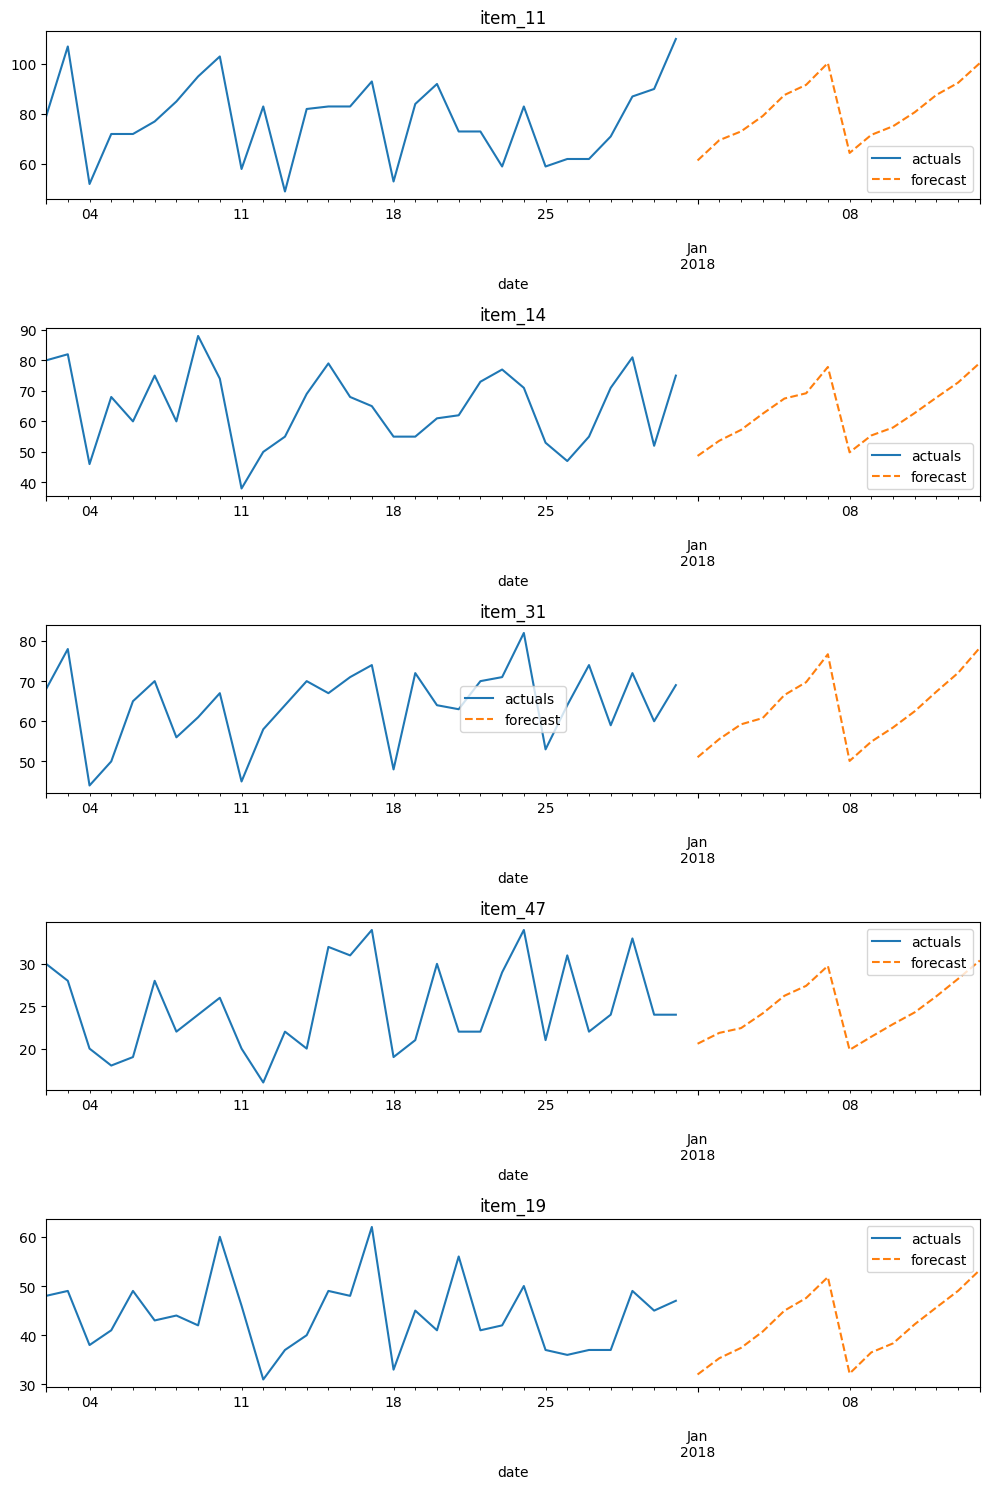

In [19]:
# Plot forecast

# Select a random subsample of timeseries
num_timeseries = 5
data_subset = data[target_cols].sample(n=num_timeseries, axis=1, random_state=123)

# Plotting
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries])
for ix in range(num_timeseries):
    item = data_subset.columns[ix]
    ax = axs[ix]

    data_subset.iloc[-30:][item].plot(ax=ax, label="actuals")
    forecast.loc[:, item].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{item}")

plt.tight_layout()

In [20]:
models["item_1"].get_feature_importances()

,feature,importance
9,day_of_week,0.396592
8,roll_std_30,0.337105
1,lag_2,0.147666
5,lag_6,0.124620
7,roll_mean_7,0.105581
4,lag_5,0.105030
0,lag_1,0.103876
2,lag_3,0.092423
3,lag_4,0.088762
6,lag_7,0.076690


## Global forecasting approach: Training one model for all time series

In [21]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Forecasters from skforecast (recursive)
from skforecast.recursive import ForecasterRecursiveMultiSeries

In [22]:
# Define a RollingFeatures object to extract window features.
# The RollingFeatures object is used with an skforecast Forecaster object.
# Calculate rolling mean and standard deviation with window 7 and 30.
window_features = RollingFeatures(
    stats = ["mean", "std"], # The statistics to calculate
    window_sizes = [7, 30], # The window sizes to calculate the statistics
)

window_features

RollingFeatures(
    stats           = ['mean', 'std'],
    window_sizes    = [7, 30],
    Max window size = 30,
    min_periods     = [7, 30],
    features_names  = ['roll_mean_7', 'roll_std_30'],
    fillna          = None
)

In [23]:
# Create and fit a forecaster

# Create forecaster
forecaster = ForecasterRecursiveMultiSeries(
    regressor=Ridge(alpha=1),
    lags=7,
    window_features=window_features,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

# REFERENCE: To create forecaster with only lag features and no window features
# forecaster = ForecasterRecursiveMultiSeries(
#     regressor=Ridge(alpha=1),
#     lags=7,
#     transformer_series=StandardScaler(),
#     transformer_exog=StandardScaler(),
# )

# Target time series column names
target_cols = data.filter(like="item_").columns

# Exogenous feature column names
exog_cols = ["day_of_week"]

forecaster.fit(
    series=data[target_cols],  # Dataframe of target time series at train time
    exog=data[exog_cols],  # Dataframe of exogenous variables at train time
)

forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: Ridge 
Lags: [1 2 3 4 5 6 7] 
Window features: ['roll_mean_7', 'roll_std_30'] 
Window size: 30 
Series encoding: ordinal 
Series names (levels): 
    item_1, item_2, item_3, item_4, item_5, item_6, item_7, item_8, item_9, item_10,
    item_11, item_12, item_13, item_14, item_15, item_16, item_17, item_18,
    item_19, item_20, item_21, item_22, item_23, item_24, item_25, item_26,
    item_27, item_28, item_29, item_30, item_31, item_32, item_33, item_34,
    item_35, item_36, item_37, item_38, item_39, item_40, item_41, item_42,
    item_43, item_44, item_45, item_46, item_47, item_48, item_49, item_50 
Exogenous included: True 
Exogenous names: day_of_week 
Transformer for series: StandardScaler() 
Transformer for exog: StandardScaler() 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'item_1': ['2013-01-01', '2017-12-31'], 'item_2': ['2013-01-01', '2017-12-31'],
    'item_3': ['2013-01-01', '2017-12-31'], 'item_4': ['2013-01-01',
    '2017-12-31'], 'item_5': ['2013-01-01', '2017-12-31'], ..., 'item_46':
    ['2013-01-01', '2017-12-31'], 'item_47': ['2013-01-01', '2017-12-31'],
    'item_48': ['2013-01-01', '2017-12-31'], 'item_49': ['2013-01-01',
    '2017-12-31'], 'item_50': ['2013-01-01', '2017-12-31'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2025-02-22 13:08:39 
Last fit date: 2025-02-22 13:08:39 
Skforecast version: 0.14.0 
Python version: 3.12.3 
Forecaster id: None

In [24]:
data.head()

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0,41.0,19.0,21.0,4.0,34.0,39.0,49.0,28.0,51.0,...,25.0,36.0,12.0,45.0,43.0,12.0,45.0,29.0,43.0,1
2013-01-02,16.0,33.0,32.0,14.0,6.0,40.0,47.0,42.0,21.0,56.0,...,21.0,35.0,25.0,50.0,52.0,13.0,37.0,25.0,57.0,2
2013-01-03,16.0,46.0,26.0,12.0,12.0,41.0,43.0,46.0,29.0,46.0,...,20.0,52.0,18.0,56.0,30.0,5.0,45.0,30.0,45.0,3
2013-01-04,20.0,50.0,34.0,17.0,16.0,41.0,44.0,55.0,32.0,56.0,...,28.0,50.0,24.0,57.0,46.0,19.0,32.0,20.0,45.0,4
2013-01-05,16.0,44.0,25.0,14.0,9.0,47.0,55.0,64.0,45.0,53.0,...,39.0,41.0,19.0,78.0,41.0,18.0,53.0,20.0,55.0,5


In [25]:
X_train, y_train = forecaster.create_train_X_y(
    series=data[target_cols], exog=data[exog_cols]
)
display(X_train.columns)
display(X_train.head(), y_train.head())

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'roll_mean_7', 'roll_std_30', '_level_skforecast', 'day_of_week'],
      dtype='object')

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,roll_mean_7,roll_std_30,_level_skforecast,day_of_week
date,,,,,,,,,,,
2013-01-31,-2.094062,-1.172258,-1.517935,-1.863611,-1.633160,-1.287484,-1.633160,-1.600239,0.501192,0,-0.001671
2013-02-01,-1.402709,-2.094062,-1.172258,-1.517935,-1.863611,-1.633160,-1.287484,-1.567317,0.494818,0,0.498400
2013-02-02,-1.402709,-1.402709,-2.094062,-1.172258,-1.517935,-1.863611,-1.633160,-1.583778,0.494818,0,0.998470
2013-02-03,-0.596131,-1.402709,-1.402709,-2.094062,-1.172258,-1.517935,-1.863611,-1.435631,0.517506,0,1.498540
2013-02-04,-1.633160,-0.596131,-1.402709,-1.402709,-2.094062,-1.172258,-1.517935,-1.402709,0.511812,0,-1.501882


date
2013-01-31   -1.402709
2013-02-01   -1.402709
2013-02-02   -0.596131
2013-02-03   -1.633160
2013-02-04   -1.172258
Name: y, dtype: float64

In [26]:
# Forecast horizon: Number of steps to predict
steps = 14

# Prepare exogenous features for the future
freq = data.index.freq.name
future_start_date = data.index.max() + pd.Timedelta(f"1{freq}")
future_dates = pd.date_range(start=future_start_date, freq=freq, periods=steps + 1)

future_exog = pd.DataFrame(index=future_dates)
future_exog["day_of_week"] = future_exog.index.weekday

In [27]:
# Predict

# Forecast for item_1 and item_2
forecast_item_1_2 = forecaster.predict(
    steps=steps, exog=future_exog, levels=["item_1", "item_2"]
)
forecast_item_1_2

,item_1,item_2
2018-01-01,16.719351,54.336382
2018-01-02,19.536238,59.700419
2018-01-03,19.884889,62.506502
2018-01-04,21.871808,65.429760
2018-01-05,23.781363,69.140459
2018-01-06,26.576121,75.881758
2018-01-07,29.329428,81.308179
2018-01-08,17.233460,54.003471
2018-01-09,19.710159,59.486936
2018-01-10,20.958061,62.452677


In [28]:
# Forecast for all items
forecast = forecaster.predict(steps=steps, exog=future_exog, levels=None)
forecast

,item_1,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,...,item_46,item_47,item_48,item_49,item_5,item_50,item_6,item_7,item_8,item_9
2018-01-01,16.719351,61.628246,62.271543,61.562401,75.450199,49.195120,76.975643,17.359141,24.694745,70.431665,...,52.103853,19.892063,40.944848,25.240959,16.579216,54.194626,48.868165,52.964760,74.719307,42.138212
2018-01-02,19.536238,69.969106,70.110309,69.074757,82.832004,54.060372,83.224240,19.641103,28.843911,76.982566,...,57.457233,21.964044,44.475098,29.219319,16.862883,58.411961,51.960185,57.196952,84.193271,48.024012
2018-01-03,19.884889,72.753928,73.817905,70.950875,85.347173,58.269274,89.406683,21.260703,29.175274,81.155967,...,61.221164,22.235556,47.577067,29.418124,18.254192,64.211691,55.413115,61.089070,87.448584,50.976819
2018-01-04,21.871808,79.251272,80.047768,76.296070,93.848132,63.136538,93.167509,22.784619,32.507063,86.248499,...,65.740986,24.151597,50.641205,31.679197,19.504194,66.959855,59.886882,65.276082,93.977527,55.049992
2018-01-05,23.781363,85.104362,87.209405,81.418613,100.763495,67.608200,100.996857,26.103874,35.127276,92.075172,...,71.261035,26.496222,56.953240,34.417206,21.748088,72.119833,64.566483,68.998474,100.633261,58.251894
2018-01-06,26.576121,91.614416,92.785381,89.619792,106.613084,69.643137,107.901422,28.142115,39.423075,97.812546,...,75.109014,27.458733,61.437233,36.860135,22.973807,78.461242,68.448951,73.933203,106.886856,63.855255
2018-01-07,29.329428,101.173787,100.209144,93.540542,114.577185,77.585329,115.868651,31.220368,43.810644,105.739522,...,80.765887,30.017630,65.990077,41.159116,25.334042,83.850598,73.336066,79.137586,114.936526,69.746638
2018-01-08,17.233460,64.743394,65.618283,62.427949,76.333168,50.337995,76.898704,17.950332,25.954368,69.695412,...,53.188988,19.130040,41.689714,25.409298,15.284370,54.364705,47.957541,52.618628,77.564927,44.078352
2018-01-09,19.710159,72.126484,72.653832,68.971087,84.145601,55.929228,84.805540,20.686502,29.564952,77.240709,...,58.840296,21.356238,46.586936,28.579721,17.166286,60.438593,53.176057,58.024377,85.168629,49.348092
2018-01-10,20.958061,75.887379,76.361960,72.461959,88.405367,59.163391,89.496328,22.267481,31.345427,81.608697,...,62.052023,22.570327,49.505662,30.091424,18.386623,64.203977,56.427762,61.200829,89.005069,52.115057


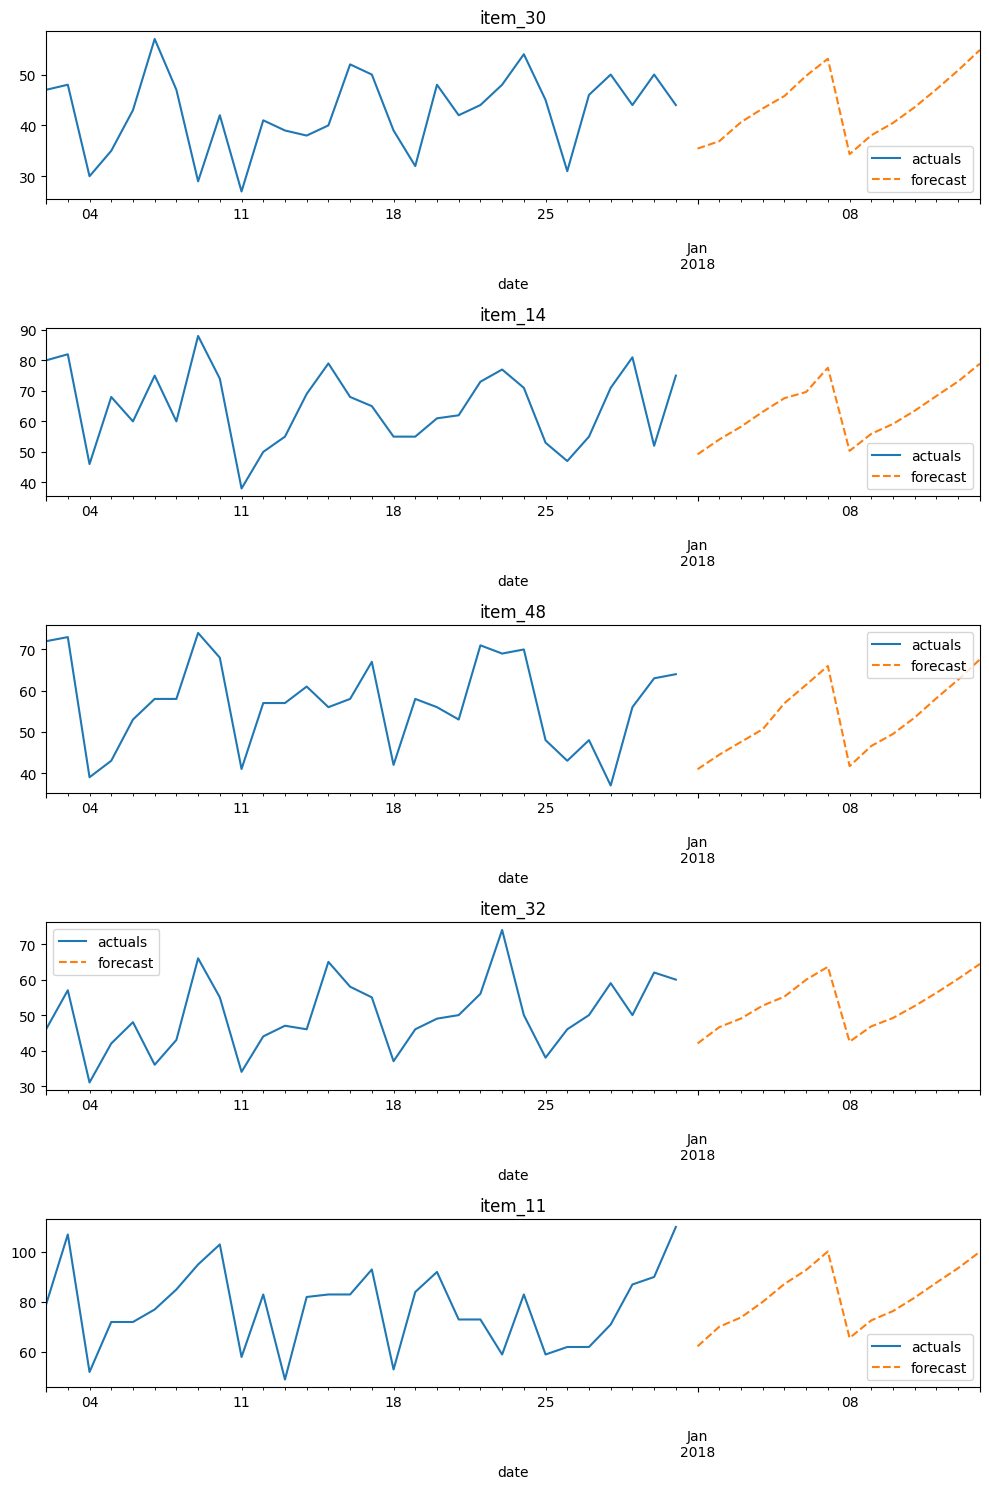

In [29]:
# Plot forecast

# Select a random subsample of timeseries
num_timeseries = 5
data_subset = data.sample(n=num_timeseries, axis=1, random_state=123)

# Plotting
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries])
for ix in range(num_timeseries):
    item = data_subset.columns[ix]
    ax = axs[ix]

    data_subset.iloc[-30:][item].plot(ax=ax, label="actuals")
    forecast.loc[:, item].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{item}")

plt.tight_layout()

In [30]:
# Interval forecasts for item_1 and item_2
# See more details here: https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/probabilistic-forecasting.html

forecast_intervals = forecaster.predict_interval(
    steps=steps, exog=future_exog, levels=["item_1", "item_2"]
)
forecast_intervals.head(3)

,item_1,item_1_lower_bound,item_1_upper_bound,item_2,item_2_lower_bound,item_2_upper_bound
2018-01-01,16.719351,7.917421,26.247218,54.336382,37.922103,71.219647
2018-01-02,19.536238,10.839176,28.825567,59.700419,44.720510,78.165118
2018-01-03,19.884889,9.996060,30.481866,62.506502,45.435495,78.639524


## Feature importance

In [31]:
# Feature importance
forecaster.get_feature_importances()

,feature,importance
10,day_of_week,0.446039
1,lag_2,0.162754
6,lag_7,0.132588
2,lag_3,0.125166
7,roll_mean_7,0.115462
3,lag_4,0.104438
4,lag_5,0.103895
5,lag_6,0.090410
0,lag_1,0.088979
8,roll_std_30,0.037894


<Axes: xlabel='feature'>

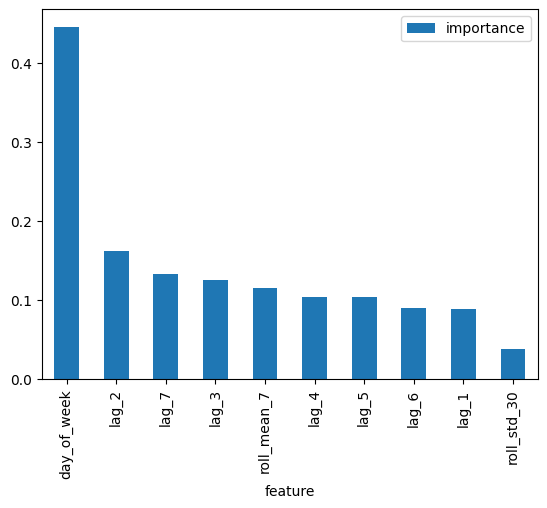

In [32]:
# Plot feature importance
(
    forecaster.get_feature_importances()
    .assign(importance=lambda df: np.abs(df.importance))
    .nlargest(n=10, columns=["importance"])
    .set_index("feature")
).plot(kind="bar")

## Weights in multi-series

The weights are used to control the influence that each observation has on the training of the model. `ForecasterAutoregMultiseries` accepts two types of weights:

+ `series_weights` controls the relative importance of each series. If a series has twice as much weight as the others, the observations of that series influence the training twice as much. The higher the weight of a series relative to the others, the more the model will focus on trying to learn that series.

+ `weight_func` controls the relative importance of each observation according to its index value. For example, a function that assigns a lower weight to certain dates.

If the two types of weights are indicated, they are **multiplied to create the final weights**. The resulting `sample_weight` cannot have negative values.

<p style="text-align: center">
<img src="./images/forecaster_multi_series_sample_weight.png" style="width: 900px">
<br>
<font size="2.5"> <i>Weights in multi-series.</i></font>
</p>

+ `series_weights` is a dict of the form `{'series_column_name': float}`. If a series is used during `fit` and is not present in `series_weights`, it will have a weight of 1.

+ `weight_func` is a function that defines the individual weights of each sample **based on the index**. 
  
    + If it is a `callable`, the same function will apply to all series. 
  
    + If it is a `dict` of the form `{'series_column_name': callable}`, a different function can be used for each series. A weight of 1 is given to all series not present in `weight_func`.

In [33]:
# Weights in Multi-Series


def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where((index >= "2013-01-01") & (index <= "2013-01-31"), 0, 1)

    return weights


forecaster = ForecasterRecursiveMultiSeries(
    regressor=Ridge(random_state=123),
    lags=24,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
    weight_func=custom_weights,
    series_weights={
        "item_1": 1.0,
        "item_2": 2.0,
        "item_3": 1.0,
    },  # Same as {'item_2': 2.}
)

forecaster.fit(series=data)
forecaster.predict(steps=24).head(3)

/Users/kishanmanani/.pyenv/versions/3.12.3/envs/general/lib/python3.12/site-packages/skforecast/recursive/_forecaster_recursive_multiseries.py:1385: IgnoredArgumentWarning: {'item_25', 'item_45', 'item_29', 'item_49', 'item_33', 'item_9', 'item_26', 'item_11', 'item_13', 'item_16', 'item_30', 'item_6', 'item_39', 'item_42', 'day_of_week', 'item_32', 'item_48', 'item_8', 'item_43', 'item_34', 'item_12', 'item_21', 'item_10', 'item_19', 'item_46', 'item_20', 'item_14', 'item_17', 'item_4', 'item_36', 'item_22', 'item_7', 'item_31', 'item_35', 'item_44', 'item_41', 'item_40', 'item_23', 'item_38', 'item_37', 'item_50', 'item_15', 'item_24', 'item_5', 'item_18', 'item_27', 'item_47', 'item_28'} not present in `series_weights`. A weight of 1 is given to all their samples. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


,day_of_week,item_1,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,...,item_46,item_47,item_48,item_49,item_5,item_50,item_6,item_7,item_8,item_9
2018-01-01,0.877232,18.877371,68.006508,64.610476,62.948850,80.911148,52.151084,83.671214,20.494370,29.339274,...,57.033499,21.765658,45.209078,28.822969,18.526683,60.288162,51.935104,55.57906,74.166571,45.710497
2018-01-02,1.367788,19.921724,66.991418,77.810994,75.888589,90.349746,52.468320,93.257480,24.272062,34.530307,...,61.535581,23.198187,50.606595,31.696759,20.346375,59.167983,56.969335,62.71426,86.557796,45.647194
2018-01-03,2.095861,19.791656,72.417070,72.525339,76.678726,82.860815,58.641490,87.523764,24.393045,29.683608,...,63.974941,24.528487,51.807266,33.364037,17.385017,67.171600,60.884956,60.18592,90.815162,52.896800


<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

The <code>weight_func</code> and <code>series_weights</code> arguments will be ignored if the regressor does not accept <code>sample_weight</code> in its <code>fit</code> method.

</div>

The source code of the `weight_func` added to the forecaster is stored in the argument `source_code_weight_func`. If `weight_func` is a `dict`, it will be a `dict` of the form `{'series_column_name': source_code_weight_func}` .